## CAM 테스트용 최소 코드
- 데이터 없어도 돌아감
- 모델 구조 확인 가능
- hook 제대로 걸리는지 확인용
- CAM 구현 들어가기 전 “환경 테스트용”

## 이 코드의 목적
- CAM 구현 X
- CAM 환경 테스트 O

1. 라이브러리

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt

2. dummy 이미지 생성 (데이터 없이 테스트 가능)

In [2]:
# (1, 3, 224, 224) 형태 더미 입력
x = torch.randn(1, 3, 224, 224)
print("input shape:", x.shape)

input shape: torch.Size([1, 3, 224, 224])


(1, 3, 224, 224)는 (batch, channel, height, width) 이미지 텐서의 형태

3. 테스트용 backbone 모델 불러오기

In [4]:
model = models.resnet18(weights=None)
model.eval()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

ResNet18이란?
- CNN 구조 중 하나
- 이미지에서 특징(feature)을 뽑는 모델
- segmentation에서도 backbone으로 많이 쓰임

4. 마지막 conv layer 찾기 (CAM 핵심)

In [6]:
target_layer = model.layer4[-1].conv2
print(target_layer)

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


conv = Convolution (합성곱)
쉽게 말하면
이미지 위를 작은 필터가 훑으면서 특징을 찾는 과정
즉, 이미지 -> conv -> 특징 맵

CAM은 "마지막 conv layer가 본 정보"를 시각화하는 기술이라서 conv layer가 중요하다.

5. Hook 함수 만들기 (CAM 준비)

In [7]:
feature_maps = []

def forward_hook(module, input, output):
    feature_maps.append(output.detach())

# hook 등록
handle = target_layer.register_forward_hook(forward_hook)

우리가 하고 싶은 건 모델 내부 중간 결과(feature map)을 보는 것.
하지만, 보통 모델은 내부를 안 보여줌.
그래서 hook = "여기 지나갈 때 나한테도 결과 알려 줘"라고 설정하는 것.

6. Forward 실행
- 정상 출력 확인

In [8]:
with torch.no_grad():
    out = model(x)

print("model output shape:", out.shape)
print("feature map shape:", feature_maps[0].shape)

model output shape: torch.Size([1, 1000])
feature map shape: torch.Size([1, 512, 7, 7])


7. 간단한 CAM 유사한 시각화 (CAM 전 단계)

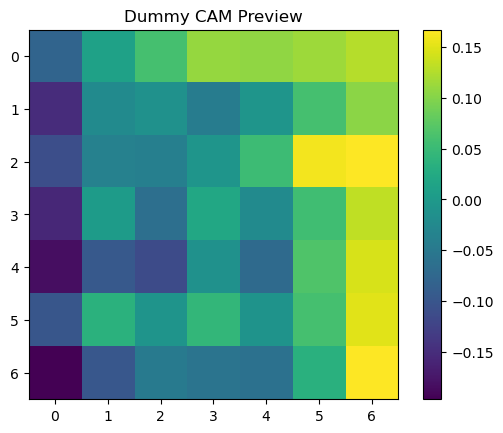

In [9]:
# 채널 평균으로 heatmap 흉내
cam = feature_maps[0].mean(dim=1).squeeze().numpy()

plt.imshow(cam)
plt.title("Dummy CAM Preview")
plt.colorbar()
plt.show()

여러 채널 feature를 평균내서 "간단한 CAM heatmap"을 만드는 과정이다.

## test_cam을 통해 확인한 것:
- model forward 정상
- last conv 찾음
- hook 작동 정상
- feature map 받아짐

### CAM 전 모델 확인사항

[ ] 모델 이름*
[ ] backbone 이름
[ ] last conv layer 위치
[ ] input size
[ ] output shape
[ ] inference 코드 위치*

1. 최종 모델 이름: (예 : DeepLabV3, U-Net, Custom CNN) - CAM 적용 방식 선택을 위함
2. backbone이 뭔지: (예 : resnet18, resnet34, efficientnet_b0) - CAM은 back 마지막 conv layer에 hook을 걸어야 해서
3. last conv layer이 어디인지: 여기에 CAM을 걸어야 해서
4. 입력 이미지 사이즈 몇인지?: CAM heatmap resize해야 해서
5. 모댈 forward 출력 shape이 뭔지: segmentation은 classfication이랑 달라서 CAM 방식도 달라지기 때문
6. inference 코드 있는지: CAM은 학습 코드 필요 없고, inference만 있으면 바로 붙일 수 있기 때문